### In this file, we consider the PDE system $\mathcal{L} \mathbf{u} = \mathbf{0}$ with Dirichlet boundary condition, where
$$
\mathcal{L}=\left[\begin{array}{cc}
1 & -\lambda \Delta \\
\lambda \Delta & 1
\end{array}\right],
\quad
\mathbf{u}=\left[\begin{array}{c} u_1 \\ u_2 \end{array}\right]
$$

In [1]:
import time
import os
import torch
import numpy as np
from torch import nn
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu_info.name}")
    print(f"GPU memory: {gpu_info.total_memory / 1024**2:.2f} MB")

GPU: NVIDIA GeForce RTX 3080 Ti
GPU memory: 12038.19 MB


In [3]:
def generate_square_points(n, plot):
    # Boundary points per side without including corners
    boundary_spacing = np.linspace(1 / (2 * n), 1 - 1 / (2 * n), n)
    
    # Bottom boundary (x varies, y is 0)
    bottom_boundary = np.column_stack((boundary_spacing, np.zeros(n)))
    # Right boundary (x is 1, y varies)
    right_boundary = np.column_stack((np.ones(n), boundary_spacing))
    # Top boundary (x varies, y is 1)
    top_boundary = np.column_stack((boundary_spacing[::-1], np.ones(n)))
    # Left boundary (x is 0, y varies)
    left_boundary = np.column_stack((np.zeros(n), boundary_spacing[::-1]))
    
    # Combine boundary points in sequence
    boundary_points = np.vstack([bottom_boundary, right_boundary, top_boundary, left_boundary])

    t_boundary = np.zeros((len(boundary_points), 1)) 
    for i in range(len(boundary_points)):
        if(boundary_points[i,1] == 0):
            t_boundary[i] = boundary_points[i,0]
        elif(boundary_points[i,0] == 1):
            t_boundary[i] = 1 + boundary_points[i,1]
        elif(boundary_points[i,1] == 1):
            t_boundary[i] = 3 - boundary_points[i,0]
        else:
            t_boundary[i] = 4 - boundary_points[i,1]

    # Generate interior points if n > 2 (excluding boundary)
    if n > 2:
        x_interior = np.linspace(0.05, 0.95, n // 8)
        y_interior = np.linspace(0.05, 0.95, n // 8)
        xx_interior, yy_interior = np.meshgrid(x_interior, y_interior)
        interior_points = np.vstack([xx_interior.ravel(), yy_interior.ravel()]).T
    else:
        interior_points = np.empty((0, 2))  # No interior points if n <= 2

    # Plotting
    if plot:
        plt.figure(figsize=(6, 6))
        plt.scatter(interior_points[:, 0], interior_points[:, 1], color='blue', label='Interior Points', s=10)
        plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color='red', label='Boundary Points', s=1)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Square Grid Points")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
    
    return 1 / n, t_boundary, boundary_points, interior_points

In [4]:
lambda_values = np.linspace(0.05, 0.1, 11)
N = 128
lambda_values = lambda_values / 2
lambda_values

array([0.025 , 0.0275, 0.03  , 0.0325, 0.035 , 0.0375, 0.04  , 0.0425,
       0.045 , 0.0475, 0.05  ])

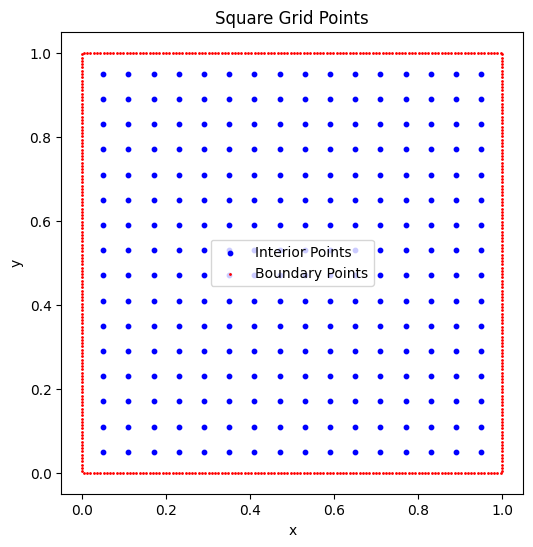

In [5]:
h, s_for_integral, x_bd, x_interior = generate_square_points(N, True)
s_for_intergal_pt = torch.from_numpy(s_for_integral).clone().float().to(device).view(-1, 1)
x_bd_pt = torch.from_numpy(x_bd).clone().float().to(device)
x_interior_pt = torch.from_numpy(x_interior).clone().float().to(device)

In [6]:
from scipy.special import keip, kerp, kei, ker

def kernel_1_1_bd(lambda_, t, s):   # lambda * G_i_j
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    
    if t < 1:
        x1_t, x2_t = t, 0
    elif t < 2:
        x1_t, x2_t = 1, t - 1
    elif t < 3:
        x1_t, x2_t = 3 - t, 1
    else:
        x1_t, x2_t = 0, 4 - t

    if (s != t):
        r = np.sqrt((x1_s - x1_t) ** 2 + (x2_s - x2_t) ** 2)
        result = - keip(r / np.sqrt(lambda_)) * (x2_prime_s * (x1_s - x1_t) - x1_prime_s * (x2_s - x2_t)) / (2 * np.pi * np.sqrt(lambda_) * r)
        return result
    else:
        return 0.
    
kernel_1_1_for_bd = torch.zeros(len(lambda_values), len(x_bd), len(x_bd))
for k in range(len(lambda_values)):
    for i in range(len(x_bd)):
        for j in range(len(x_bd)):
            kernel_1_1_for_bd[k, i, j] = h * kernel_1_1_bd(lambda_values[k], s_for_integral[i, 0], s_for_integral[j, 0])

In [7]:
def kernel_1_2_bd(lambda_, t, s):   # lambda * G_i_j
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    
    if t < 1:
        x1_t, x2_t = t, 0
    elif t < 2:
        x1_t, x2_t = 1, t - 1
    elif t < 3:
        x1_t, x2_t = 3 - t, 1
    else:
        x1_t, x2_t = 0, 4 - t

    if (s != t):
        r = np.sqrt((x1_s - x1_t) ** 2 + (x2_s - x2_t) ** 2)
        result = - kerp(r / np.sqrt(lambda_)) * (x2_prime_s * (x1_s - x1_t) - x1_prime_s * (x2_s - x2_t)) / (2 * np.pi * np.sqrt(lambda_) * r)
        return result
    else:
        return 0.
    
kernel_1_2_for_bd = torch.zeros(len(lambda_values), len(x_bd), len(x_bd))
for k in range(len(lambda_values)):
    for i in range(len(x_bd)):
        for j in range(len(x_bd)):
            kernel_1_2_for_bd[k, i, j] = h * kernel_1_2_bd(lambda_values[k], s_for_integral[i, 0], s_for_integral[j, 0])

In [8]:
def kernel_2_1_bd(lambda_, t, s):   # lambda * G_i_j
    return - kernel_1_2_bd(lambda_, t, s)
    
kernel_2_1_for_bd = torch.zeros(len(lambda_values), len(x_bd), len(x_bd))
for k in range(len(lambda_values)):
    for i in range(len(x_bd)):
        for j in range(len(x_bd)):
            kernel_2_1_for_bd[k, i, j] = h * kernel_2_1_bd(lambda_values[k], s_for_integral[i, 0], s_for_integral[j, 0])

In [9]:
def kernel_2_2_bd(lambda_, t, s):   # lambda * G_i_j
    return kernel_1_1_bd(lambda_, t, s)
    
kernel_2_2_for_bd = torch.zeros(len(lambda_values), len(x_bd), len(x_bd))
for k in range(len(lambda_values)):
    for i in range(len(x_bd)):
        for j in range(len(x_bd)):
            kernel_2_2_for_bd[k, i, j] = h * kernel_2_2_bd(lambda_values[k], s_for_integral[i, 0], s_for_integral[j, 0])

In [10]:
def predict_u_bd(net, lambda_, g):      
    # net: (batch_size, 2 * n_g) to (batch_size, 2 * n_g); lambda_: scalar; g: (batch_size, 2 * n_g)

    flag = 0
    for i in range(len(lambda_values)):
        if np.abs(lambda_ - lambda_values[i]) < 1e-6:
            kernel_1_1 = kernel_1_1_for_bd[i, :, :].to(device)
            kernel_1_2 = - kernel_1_2_for_bd[i, :, :].to(device)
            kernel_2_1 = kernel_2_1_for_bd[i, :, :].to(device)
            kernel_2_2 = - kernel_2_2_for_bd[i, :, :].to(device)
            flag = 1
            # print(taus[i])
            
    if flag == 0: 
        if lambda_ > 0:
            kernel_1_1 = torch.zeros(len(x_bd), len(x_bd))
            kernel_1_2 = torch.zeros(len(x_bd), len(x_bd))
            kernel_2_1 = torch.zeros(len(x_bd), len(x_bd))
            kernel_2_2 = torch.zeros(len(x_bd), len(x_bd))
            for i in range(len(x_bd)):
                for j in range(len(x_bd)):
                    kernel_1_1[i, j] = h * kernel_1_1_bd(lambda_, s_for_integral[i, 0], s_for_integral[j, 0])
                    kernel_1_2[i, j] = h * kernel_1_2_bd(lambda_, s_for_integral[i, 0], s_for_integral[j, 0])
                    kernel_2_1[i, j] = h * kernel_2_1_bd(lambda_, s_for_integral[i, 0], s_for_integral[j, 0])
                    kernel_2_2[i, j] = h * kernel_2_2_bd(lambda_, s_for_integral[i, 0], s_for_integral[j, 0])
            kernel_1_1 = kernel_1_1.to(device)
            kernel_1_2 = - kernel_1_2.to(device)
            kernel_2_1 = kernel_2_1.to(device)
            kernel_2_2 = - kernel_2_2.to(device)
        else:
            exit("The value of lambda is illegal!")

    phi = net(lambda_, g)
    phi1, phi2 = phi[:, 0: 4 * N], phi[:, 4 * N: 8 * N]
    k1 = (0.5 * phi1.T - kernel_1_1 @ phi2.T - kernel_1_2 @ phi1.T).T
    k2 = (0.5 * phi2.T - kernel_2_1 @ phi2.T - kernel_2_2 @ phi1.T).T

    return k1, k2, torch.cat((k1, k2), dim=1)

In [11]:
def kernel_1_1_int(lambda_, x, s):  # lambda * G_i_j
    x1, x2 = x[0], x[1]
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    r = np.sqrt((x1_s - x1) ** 2 + (x2_s - x2) ** 2)
    result = - keip(r / np.sqrt(lambda_)) * (x2_prime_s * (x1_s - x1) - x1_prime_s * (x2_s - x2)) / (2 * np.pi * np.sqrt(lambda_) * r)
    return result

kernel_1_1_for_int = torch.zeros(len(lambda_values), len(x_interior), len(x_bd))
for k in range(len(lambda_values)):
    for i in range(len(x_interior)):
        for j in range(len(x_bd)):
            kernel_1_1_for_int[k, i, j] = h * kernel_1_1_int(lambda_values[k], x_interior[i, :], s_for_integral[j, 0])

In [12]:
def kernel_1_2_int(lambda_, x, s):  # lambda * G_i_j
    x1, x2 = x[0], x[1]
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    r = np.sqrt((x1_s - x1) ** 2 + (x2_s - x2) ** 2)
    result = - kerp(r / np.sqrt(lambda_)) * (x2_prime_s * (x1_s - x1) - x1_prime_s * (x2_s - x2)) / (2 * np.pi * np.sqrt(lambda_) * r)
    return result

kernel_1_2_for_int = torch.zeros(len(lambda_values), len(x_interior), len(x_bd))
for k in range(len(lambda_values)):
    for i in range(len(x_interior)):
        for j in range(len(x_bd)):
            kernel_1_2_for_int[k, i, j] = h * kernel_1_2_int(lambda_values[k], x_interior[i, :], s_for_integral[j, 0])

In [13]:
def kernel_2_1_int(lambda_, x, s):  # lambda * G_i_j
    return - kernel_1_2_int(lambda_, x, s)

kernel_2_1_for_int = torch.zeros(len(lambda_values), len(x_interior), len(x_bd))
for k in range(len(lambda_values)):
    for i in range(len(x_interior)):
        for j in range(len(x_bd)):
            kernel_2_1_for_int[k, i, j] = h * kernel_2_1_int(lambda_values[k], x_interior[i, :], s_for_integral[j, 0])

In [14]:
def kernel_2_2_int(lambda_, x, s):  # lambda * G_i_j
    return kernel_1_1_int(lambda_, x, s)

kernel_2_2_for_int = torch.zeros(len(lambda_values), len(x_interior), len(x_bd))
for k in range(len(lambda_values)):
    for i in range(len(x_interior)):
        for j in range(len(x_bd)):
            kernel_2_2_for_int[k, i, j] = h * kernel_2_2_int(lambda_values[k], x_interior[i, :], s_for_integral[j, 0])

In [15]:
def predict_u_int(net, lambda_, g):      
    # net: (batch_size, 2 * n_g) to (batch_size, 2 * n_g); lambda_: scalar; g: (batch_size, 2 * n_g)

    flag = 0
    for i in range(len(lambda_values)):
        if np.abs(lambda_ - lambda_values[i]) < 1e-6:
            kernel_1_1 = kernel_1_1_for_int[i, :, :].to(device)
            kernel_1_2 = - kernel_1_2_for_int[i, :, :].to(device)
            kernel_2_1 = kernel_2_1_for_int[i, :, :].to(device)
            kernel_2_2 = - kernel_2_2_for_int[i, :, :].to(device)
            flag = 1
            # print(taus[i])
            
    if flag == 0:
        if lambda_ > 0:
            kernel_1_1 = torch.zeros(len(x_interior), len(x_bd))
            kernel_1_2 = torch.zeros(len(x_interior), len(x_bd))
            kernel_2_1 = torch.zeros(len(x_interior), len(x_bd))
            kernel_2_2 = torch.zeros(len(x_interior), len(x_bd))
            for i in range(len(x_interior)):
                for j in range(len(x_bd)):
                    kernel_1_1[i, j] = h * kernel_1_1_int(lambda_, x_interior[i, :], s_for_integral[j, 0])
                    kernel_1_2[i, j] = h * kernel_1_2_int(lambda_, x_interior[i, :], s_for_integral[j, 0])
                    kernel_2_1[i, j] = h * kernel_2_1_int(lambda_, x_interior[i, :], s_for_integral[j, 0])
                    kernel_2_2[i, j] = h * kernel_2_2_int(lambda_, x_interior[i, :], s_for_integral[j, 0])
            kernel_1_1 = kernel_1_1.to(device)
            kernel_1_2 = - kernel_1_2.to(device)
            kernel_2_1 = kernel_2_1.to(device)
            kernel_2_2 = - kernel_2_2.to(device)
        else:
            exit("The value of lambda is illegal!")

    phi = net(lambda_, g)
    phi1, phi2 = phi[:, 0: 4 * N], phi[:, 4 * N: 8 * N]

    k1 = (-kernel_1_1 @ phi2.T - kernel_1_2 @ phi1.T).T
    k2 = (-kernel_2_1 @ phi2.T - kernel_2_2 @ phi1.T).T

    return k1, k2

In [16]:
from scipy.ndimage import gaussian_filter

def generate_exact_solution_1(num_samples, n, sigma):
    g_list = []
    for _ in range(num_samples):
        g = np.random.randn(n)
        g = gaussian_filter(g, sigma=sigma)
        g_list.append(g)
    return g_list

def generate_exact_solution_2(num_samples):
    g_list = []
    x = x_bd[:, 0].reshape(-1)
    y = x_bd[:, 1].reshape(-1)

    for _ in range(num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.sin(b * np.pi * x) * np.sin(c * np.pi * y)
        g_list.append(g)

    for _ in range(num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.cos(b * np.pi * x) * np.cos(c * np.pi * y)
        g_list.append(g)

    for _ in range(num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.sin(b * np.pi * x) * np.cos(c * np.pi * y)
        g_list.append(g)

    for _ in range(num_samples - num_samples // 4 - num_samples // 4 - num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.cos(b * np.pi * x) * np.sin(c * np.pi * y)
        g_list.append(g)

    return g_list

def generate_g(num_of_samples):

    g_1 = generate_exact_solution_1(num_of_samples // 10, 8 * N, 1)
    g_2 = generate_exact_solution_1(num_of_samples // 10, 8 * N, 2)
    g_3 = generate_exact_solution_1(num_of_samples // 10, 8 * N, 3)
    g_4 = generate_exact_solution_1(num_of_samples // 10, 8 * N, 4)
    g_5 = generate_exact_solution_1(num_of_samples // 10, 8 * N, 5)
    g_6_1 = generate_exact_solution_2(num_of_samples - 5 * (num_of_samples // 10))
    g_6_2 = generate_exact_solution_2(num_of_samples - 5 * (num_of_samples // 10))

    g_list = g_1 + g_2 + g_3 + g_4 + g_5
    g_1_5 = np.array(g_list)
    g_6 = np.concatenate((g_6_1, g_6_2), 1)

    return np.concatenate((g_1_5, g_6), 0)

In [17]:
g_np = generate_g(10000)

In [18]:
# np.linalg.matrix_rank(g_np, tol=1e-6)
g_np.shape

(10000, 1024)

In [19]:
class MLP(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers):
        super(MLP, self).__init__()
        self.act = nn.ReLU()
        self.layin = torch.nn.Linear(n_input, n_hidden)
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(n_hidden, n_hidden) for _ in range(n_layers)])
        self.layout = torch.nn.Linear(n_hidden, n_output)
    def forward(self, g):
       g = self.layin(g)
       g = self.act(g)
       for layer in self.hidden_layers:
           g = layer(g)
           g = self.act(g)
       h = self.layout(g)
       return h
    
class DeepONet(torch.nn.Module):
    def __init__(self, N):
        super(DeepONet, self).__init__()
        self.for_tau = MLP(1, N, N, 2)
        self.for_g_1 = torch.nn.Linear(N, N, bias = False)
        self.for_g_2 = torch.nn.Linear(N, N, bias = False)
    def forward(self, tau, g):      #  tau: scalar, g: (batch_size, n_g)
       tau = tau + torch.zeros_like(g[:, 1].view(-1, 1))
       tau = self.for_tau(tau)
       g = self.for_g_1(g)
       h = self.for_g_2(tau * g)
       return h

In [20]:
from torch.utils.data import TensorDataset, DataLoader, random_split

g_pt = torch.tensor(g_np, dtype=torch.float32).to(device)
dataset = TensorDataset(g_pt)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_g = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
test_g = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])

In [21]:
criterion = nn.MSELoss()
def compute_loss(net, g):
    predictions = torch.cat([predict_u_bd(net, lambda_, g)[2].unsqueeze(0) for lambda_ in lambda_values], dim=0)
    targets = g.unsqueeze(0).repeat(len(lambda_values), 1, 1)
    loss = criterion(predictions, targets)
    return loss

In [23]:
import time
import torch.optim.lr_scheduler as lr_scheduler

net = DeepONet(8 * N).to(device)
parameters = net.parameters()

t0 = time.time()

train_loss_all = []
best_train_loss = 1.0
num_epochs = 100000
optimizer = torch.optim.Adam(parameters, lr = 1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 1000, factor = 0.7)

patience = 50000  
early_stopping_counter = 0

for epoch in range(num_epochs):
    
    net.train()
        
    optimizer.zero_grad()
    loss = compute_loss(net, train_g)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    net.eval()
    loss_test = compute_loss(net, test_g)

    if (epoch + 1) % 50 == 0:
        print("Epoch {}/{}".format(epoch + 1, num_epochs), "||  loss:", loss.item(), "||  loss_test:", loss_test.item(), "|| lr:", scheduler.get_last_lr())
        print("*" * 50)
    
    # Save the best model
    if loss_test.item() < best_train_loss:
        best_train_loss = loss_test.item()
        torch.save(net.state_dict(), "net.pth")
        early_stopping_counter = 0  # Reset counter
    else:
        early_stopping_counter += 1

    # Early stopping check
    if early_stopping_counter >= patience:
        print(f"Early stopping triggered! Best validation loss: {best_train_loss:.6f}, achieved at epoch {epoch + 1 - patience}.")
        break

T = time.time() - t0
print("Total training time: {:.2f} seconds".format(T))

Epoch 50/100000 ||  loss: 0.046449095010757446 ||  loss_test: 0.04591673985123634 || lr: [0.001]
**************************************************
Epoch 100/100000 ||  loss: 0.03188365325331688 ||  loss_test: 0.032337553799152374 || lr: [0.001]
**************************************************
Epoch 150/100000 ||  loss: 0.01737610436975956 ||  loss_test: 0.019531942903995514 || lr: [0.001]
**************************************************
Epoch 200/100000 ||  loss: 0.009731611236929893 ||  loss_test: 0.01252110954374075 || lr: [0.001]
**************************************************
Epoch 250/100000 ||  loss: 0.006182418670505285 ||  loss_test: 0.00899298395961523 || lr: [0.001]
**************************************************
Epoch 300/100000 ||  loss: 0.004351447336375713 ||  loss_test: 0.006995804142206907 || lr: [0.001]
**************************************************
Epoch 350/100000 ||  loss: 0.0033450813498347998 ||  loss_test: 0.005711542908102274 || lr: [0.001]
******

In [24]:
net.load_state_dict(torch.load("net.pth", map_location = device))

/tmp/ipykernel_13539/2391093717.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("net.pth", map_location = device))


<All keys matched successfully>

In [25]:
def compute_errors(predicted_u, exact_u):
    error_inf_abs = torch.max(torch.abs(predicted_u - exact_u))
    error_2_abs = torch.norm(predicted_u - exact_u, p=2) / torch.sqrt(torch.tensor(exact_u.numel(), dtype=torch.float))

    error_inf_rel = error_inf_abs / torch.max(torch.abs(exact_u))
    error_2_rel = torch.norm(predicted_u - exact_u, p=2) / torch.norm(exact_u, p=2)

    print("L_inf absolute error:", error_inf_abs.item(), "|| L_2 absolute error:", error_2_abs.item())
    print("L_inf relative error:", error_inf_rel.item(), "|| L_2 relative error:", error_2_rel.item()) 

def plot(u_int_pre, u_int_exact, u_bd_pre, u_bd_exact):
    x_all = np.concatenate([x_interior, x_bd], axis=0)
    # print(x_all.shape)

    u_exact = np.concatenate([u_int_exact.cpu().detach().numpy(), u_bd_exact.cpu().detach().numpy()], axis=1).T
    # print(u_exact.shape)

    u_pre = np.concatenate([u_int_pre.cpu().detach().numpy(), u_bd_pre.cpu().detach().numpy()], axis = 1).T
    # print(u_pre.shape)
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
    
    sc = axs[0].scatter(x_all[:, 0], x_all[:, 1], c=u_exact, cmap='viridis', marker='o', s=20)
    axs[0].set_xlabel("X coordinate")
    axs[0].set_ylabel("Y coordinate")
    axs[0].set_title(f"Exact solution")
    axs[0].set_aspect('equal')
    fig.colorbar(sc, ax=axs[0], orientation='vertical', label="U values")

    sc = axs[1].scatter(x_all[:, 0], x_all[:, 1], c=u_pre, cmap='viridis', marker='o', s=20)
    axs[1].set_xlabel("X coordinate")
    axs[1].set_ylabel("Y coordinate")
    axs[1].set_title(f"Numerical solution")
    axs[1].set_aspect('equal')
    fig.colorbar(sc, ax=axs[1], orientation='vertical', label="U values")

    sc = axs[2].scatter(x_all[:, 0], x_all[:, 1], c=u_exact - u_pre, cmap='viridis', marker='o', s=20)
    axs[2].set_xlabel("X coordinate")
    axs[2].set_ylabel("Y coordinate")
    axs[2].set_title(f"Error")
    axs[2].set_aspect('equal')
    fig.colorbar(sc, ax=axs[2], orientation='vertical', label="Error values")

    plt.show()

    compute_errors(torch.from_numpy(u_pre), torch.from_numpy(u_exact)) 

In [26]:
a = 1.2

def U1(lambda_, x):
    x_np = x.cpu().detach().numpy()
    x1 = x_np[:, 0].reshape((-1, 1))
    x2 = x_np[:, 1].reshape((-1, 1))
    r = np.sqrt((x1 - a) * (x1 - a) + (x2 - a) * (x2 - a))
    ans_np = - kei(r / np.sqrt(lambda_)) / (2 * np.pi * lambda_) 
    return torch.from_numpy(ans_np).clone().float().to(device)

def U2(lambda_, x):
    x_np = x.cpu().detach().numpy()
    x1 = x_np[:, 0].reshape((-1, 1))
    x2 = x_np[:, 1].reshape((-1, 1))
    r = np.sqrt((x1 - a) * (x1 - a) + (x2 - a) * (x2 - a))
    ans_np = ker(r / np.sqrt(lambda_)) / (2 * np.pi * lambda_) 
    return torch.from_numpy(ans_np).clone().float().to(device)

def validation(lambda_, net):
    g1 = U1(lambda_, x_bd_pt).view(1, -1)
    g2 = U2(lambda_, x_bd_pt).view(1, -1)
    g = torch.cat((g1, g2), dim = 1)    # (1, 8 * N)
    
    u1_int_pre, u2_int_pre = predict_u_int(net, lambda_, g)
    u1_int_exact, u2_int_exact = U1(lambda_, x_interior_pt).view(1, -1), U2(lambda_, x_interior_pt).view(1, -1)
    u1_bd_pre, u2_bd_pre, _ = predict_u_bd(net, lambda_, g)
    u1_bd_exact, u2_bd_exact = U1(lambda_, x_bd_pt).view(1, -1), U2(lambda_, x_bd_pt).view(1, -1)

    print("numerical result for u_1:")
    print("In the domain: ")
    compute_errors(u1_int_pre, u1_int_exact)

    print("On the boundary:")
    compute_errors(u1_bd_pre, u1_bd_exact)

    plot(u1_int_pre, u1_int_exact, u1_bd_pre, u1_bd_exact)

    print("numerical result for u_2:")
    print("In the domain: ")
    compute_errors(u2_int_pre, u2_int_exact)

    print("On the boundary:")
    compute_errors(u2_bd_pre, u2_bd_exact)

    plot(u2_int_pre, u2_int_exact, u2_bd_pre, u2_bd_exact)

numerical result for u_1:
In the domain: 
L_inf absolute error: 0.0007432103157043457 || L_2 absolute error: 8.26383475214243e-05
L_inf relative error: 0.0007583433762192726 || L_2 relative error: 0.000505075033288449
On the boundary:
L_inf absolute error: 0.0006983280181884766 || L_2 absolute error: 0.00017370624118484557
L_inf relative error: 0.0005475872894749045 || L_2 relative error: 0.0005119371926411986


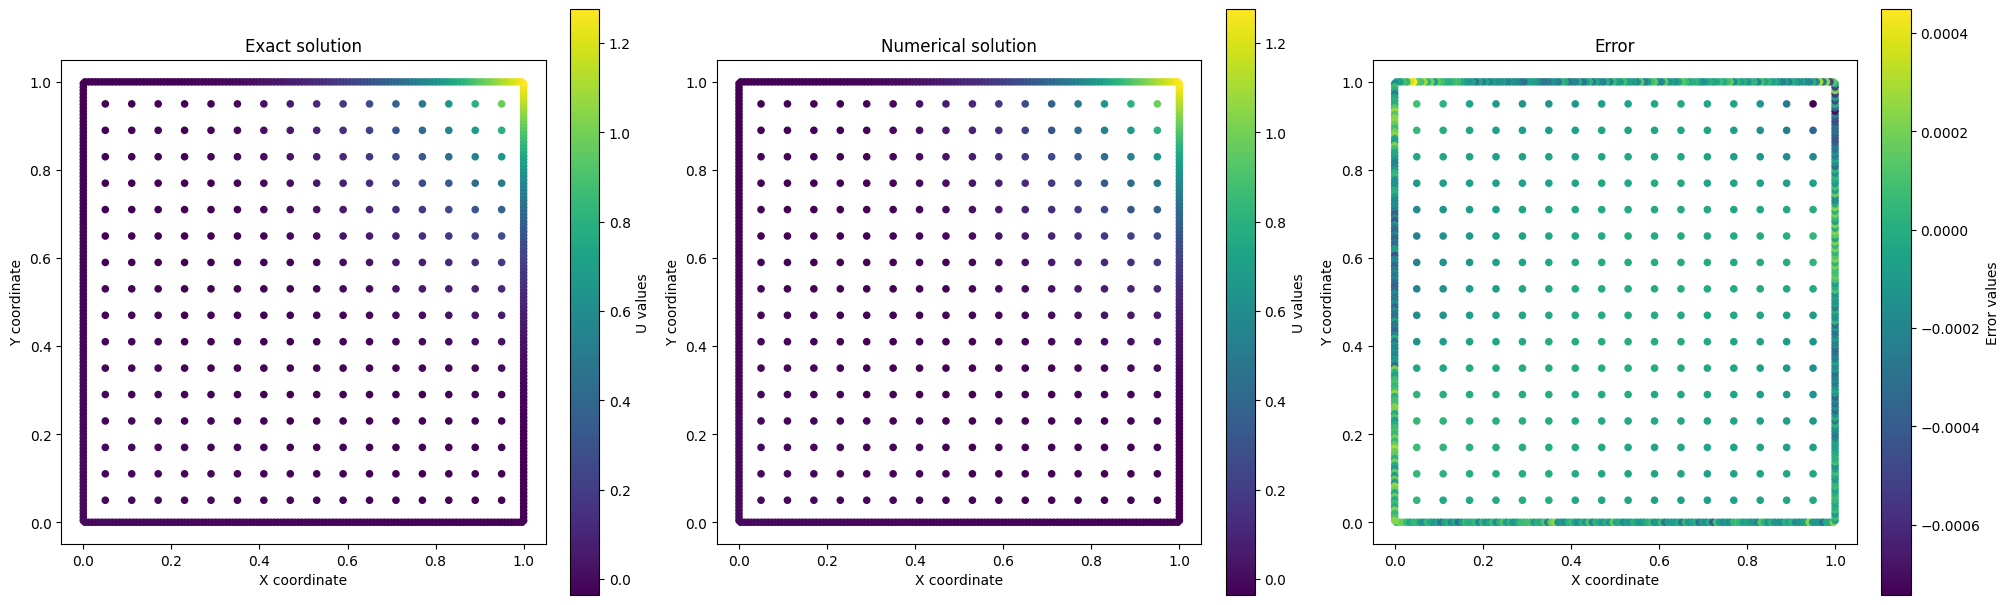

L_inf absolute error: 0.0007432103157043457 || L_2 absolute error: 0.00014964047295507044
L_inf relative error: 0.0005827813292853534 || L_2 relative error: 0.0005112267681397498
numerical result for u_2:
In the domain: 
L_inf absolute error: 0.0002721250057220459 || L_2 absolute error: 6.470693915616721e-05
L_inf relative error: 0.0012046350166201591 || L_2 relative error: 0.0006014332757331431
On the boundary:
L_inf absolute error: 0.0005065985023975372 || L_2 absolute error: 0.0001586431171745062
L_inf relative error: 0.0011957157403230667 || L_2 relative error: 0.0013931251596659422


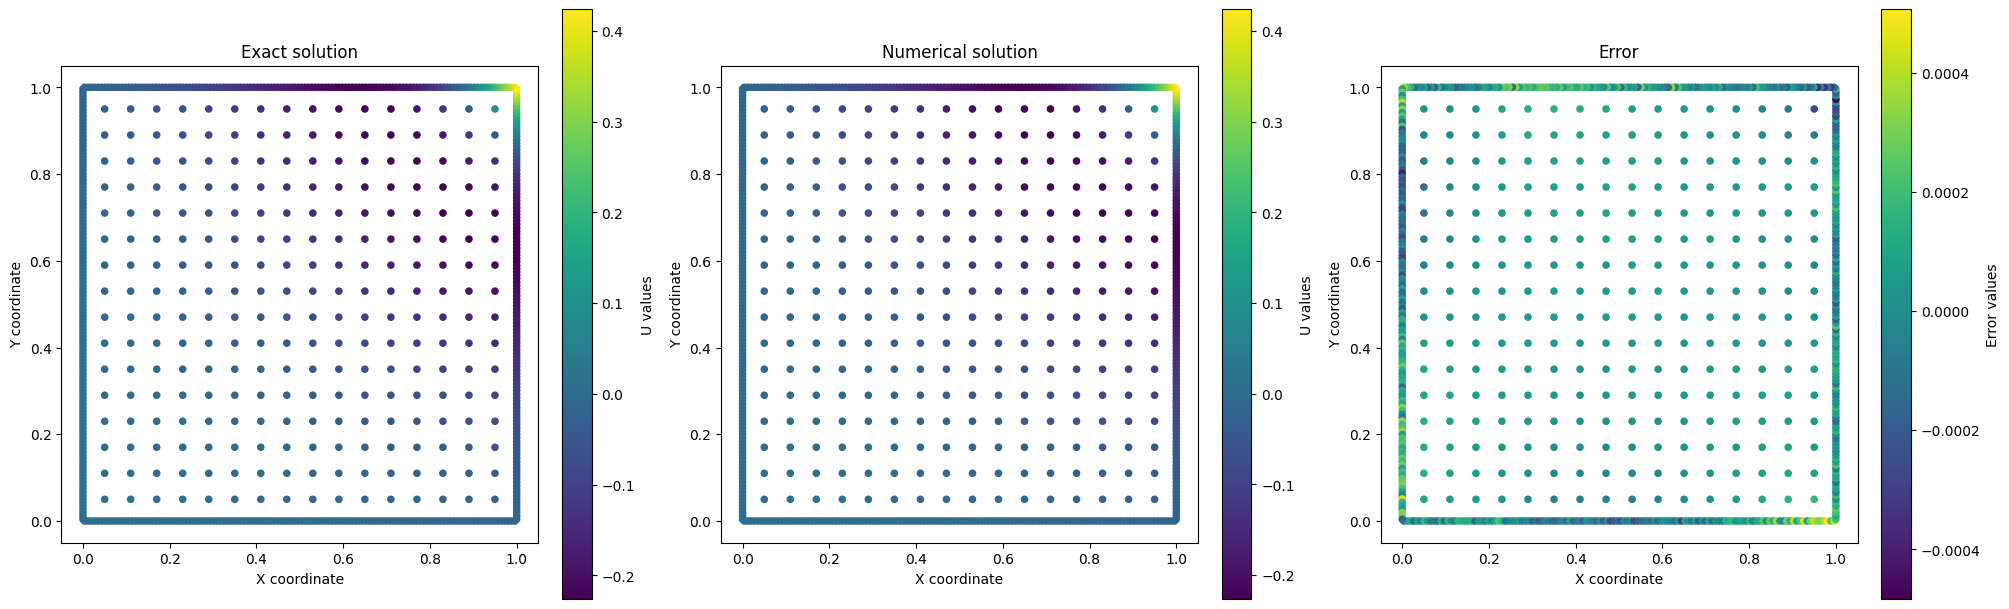

L_inf absolute error: 0.0005065985023975372 || L_2 absolute error: 0.00013481131463777274
L_inf relative error: 0.0011957157403230667 || L_2 relative error: 0.0012056201230734587


In [27]:
validation(0.05, net)

numerical result for u_1:
In the domain: 
L_inf absolute error: 0.0005091428756713867 || L_2 absolute error: 4.143983460380696e-05
L_inf relative error: 0.0004921609070152044 || L_2 relative error: 0.0003009102656506002
On the boundary:
L_inf absolute error: 0.0005519390106201172 || L_2 absolute error: 0.0001361052127322182
L_inf relative error: 0.00036972222733311355 || L_2 relative error: 0.00039265555096790195


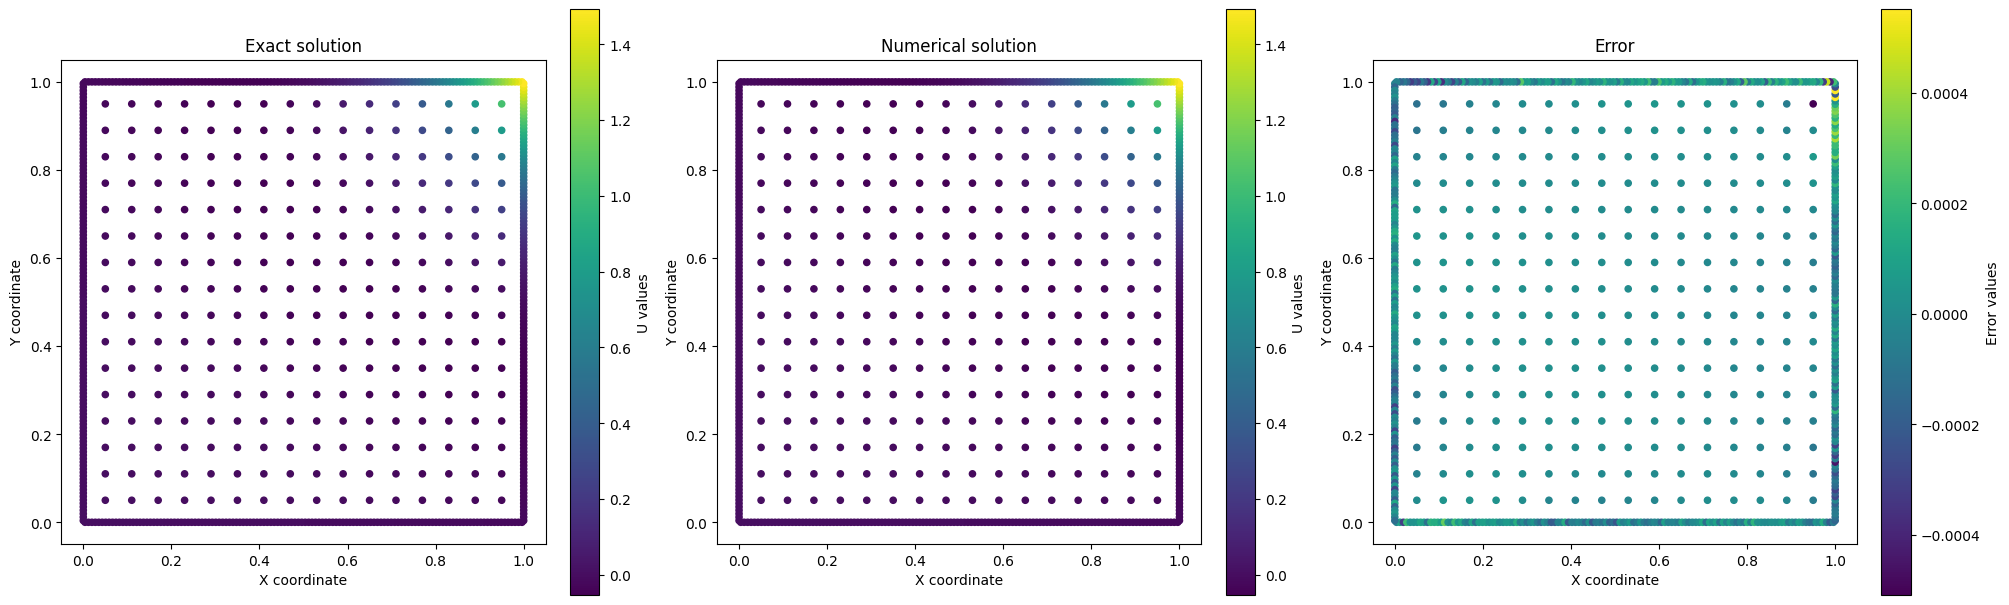

L_inf absolute error: 0.0005519390106201172 || L_2 absolute error: 0.0001136757418862544
L_inf relative error: 0.00036972222733311355 || L_2 relative error: 0.00038668300840072334
numerical result for u_2:
In the domain: 
L_inf absolute error: 0.00017004646360874176 || L_2 absolute error: 4.946117041981779e-05
L_inf relative error: 0.0005015963106416166 || L_2 relative error: 0.00041472865268588066
On the boundary:
L_inf absolute error: 0.00042765215039253235 || L_2 absolute error: 0.00014055814244784415
L_inf relative error: 0.001261198427528143 || L_2 relative error: 0.0010460494086146355


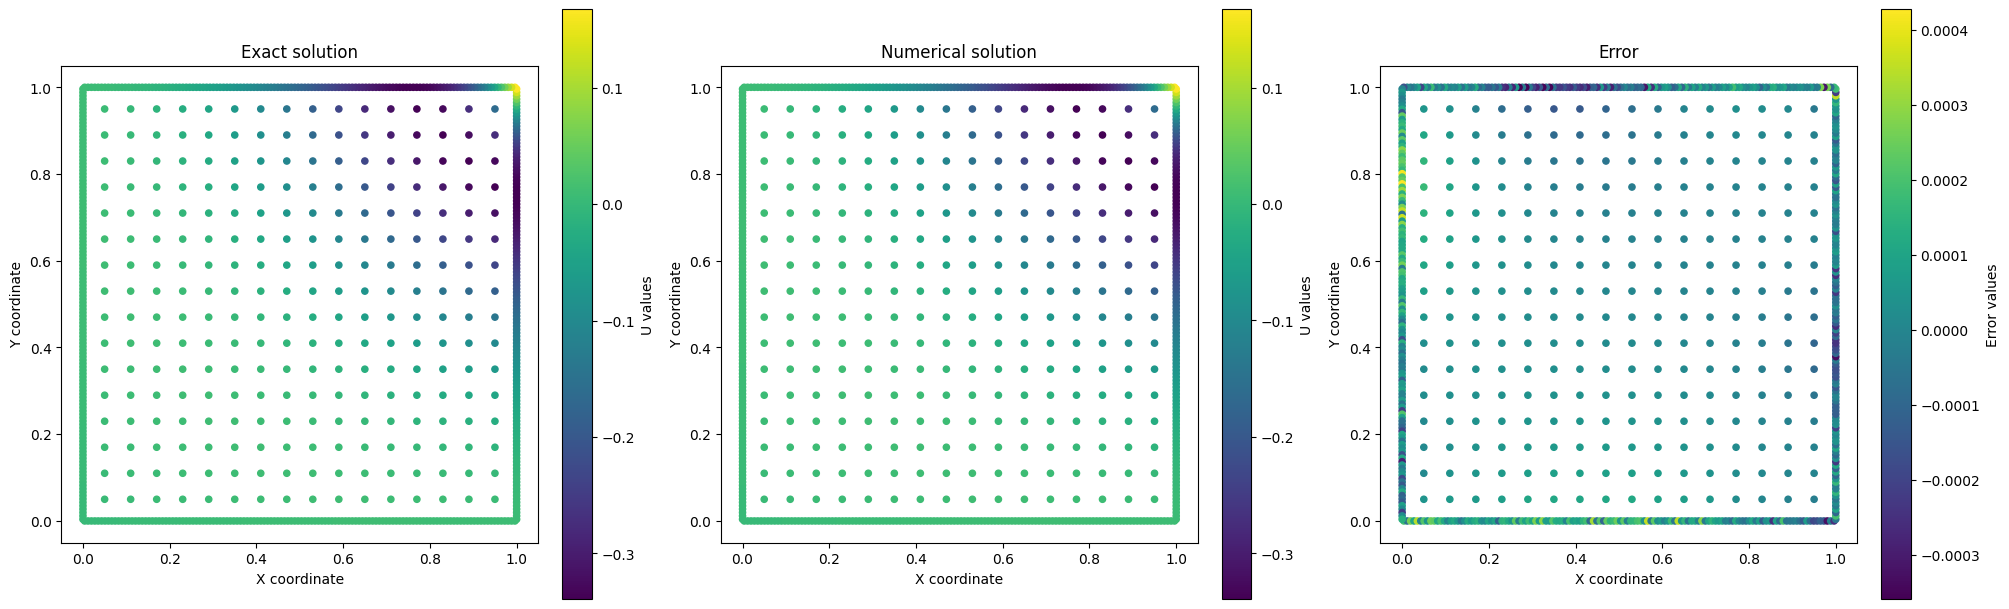

L_inf absolute error: 0.00042765215039253235 || L_2 absolute error: 0.00011826465924968943
L_inf relative error: 0.001261198427528143 || L_2 relative error: 0.0009130282560363412


In [28]:
validation(1/30, net)

numerical result for u_1:
In the domain: 
L_inf absolute error: 0.0006912946701049805 || L_2 absolute error: 6.216333713382483e-05
L_inf relative error: 0.0007020762423053384 || L_2 relative error: 0.0005518923280760646
On the boundary:
L_inf absolute error: 0.0008036447688937187 || L_2 absolute error: 0.00020268058869987726
L_inf relative error: 0.0005093964864499867 || L_2 relative error: 0.000612849195022136


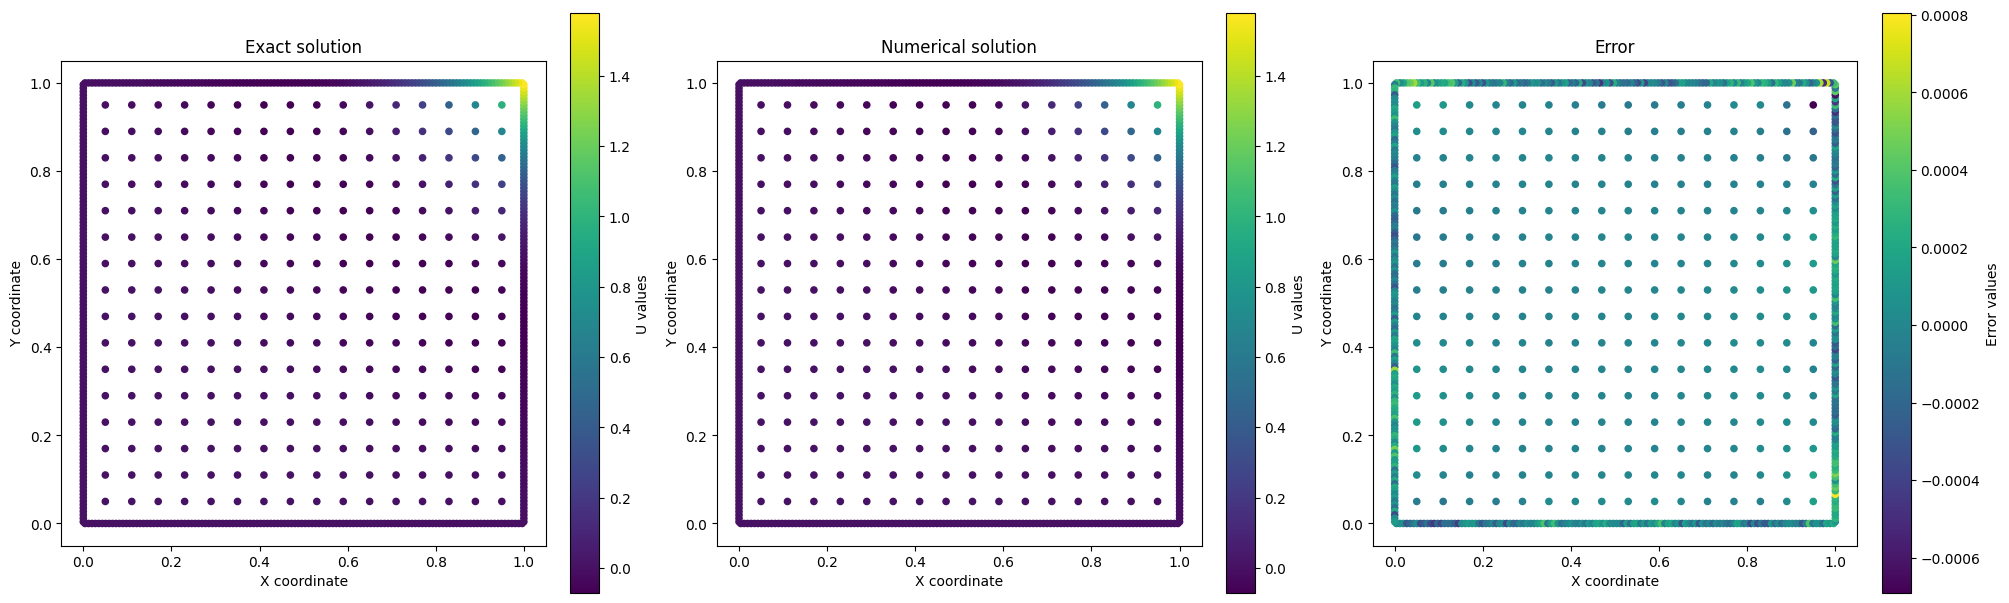

L_inf absolute error: 0.0008036447688937187 || L_2 absolute error: 0.00016933510778471828
L_inf relative error: 0.0005093964864499867 || L_2 relative error: 0.0006096655270084739
numerical result for u_2:
In the domain: 
L_inf absolute error: 0.0003623068332672119 || L_2 absolute error: 6.759479583706707e-05
L_inf relative error: 0.0008066277951002121 || L_2 relative error: 0.0005456657963804901
On the boundary:
L_inf absolute error: 0.0008935630321502686 || L_2 absolute error: 0.00023088004672899842
L_inf relative error: 0.0019766087643802166 || L_2 relative error: 0.0013710426865145564


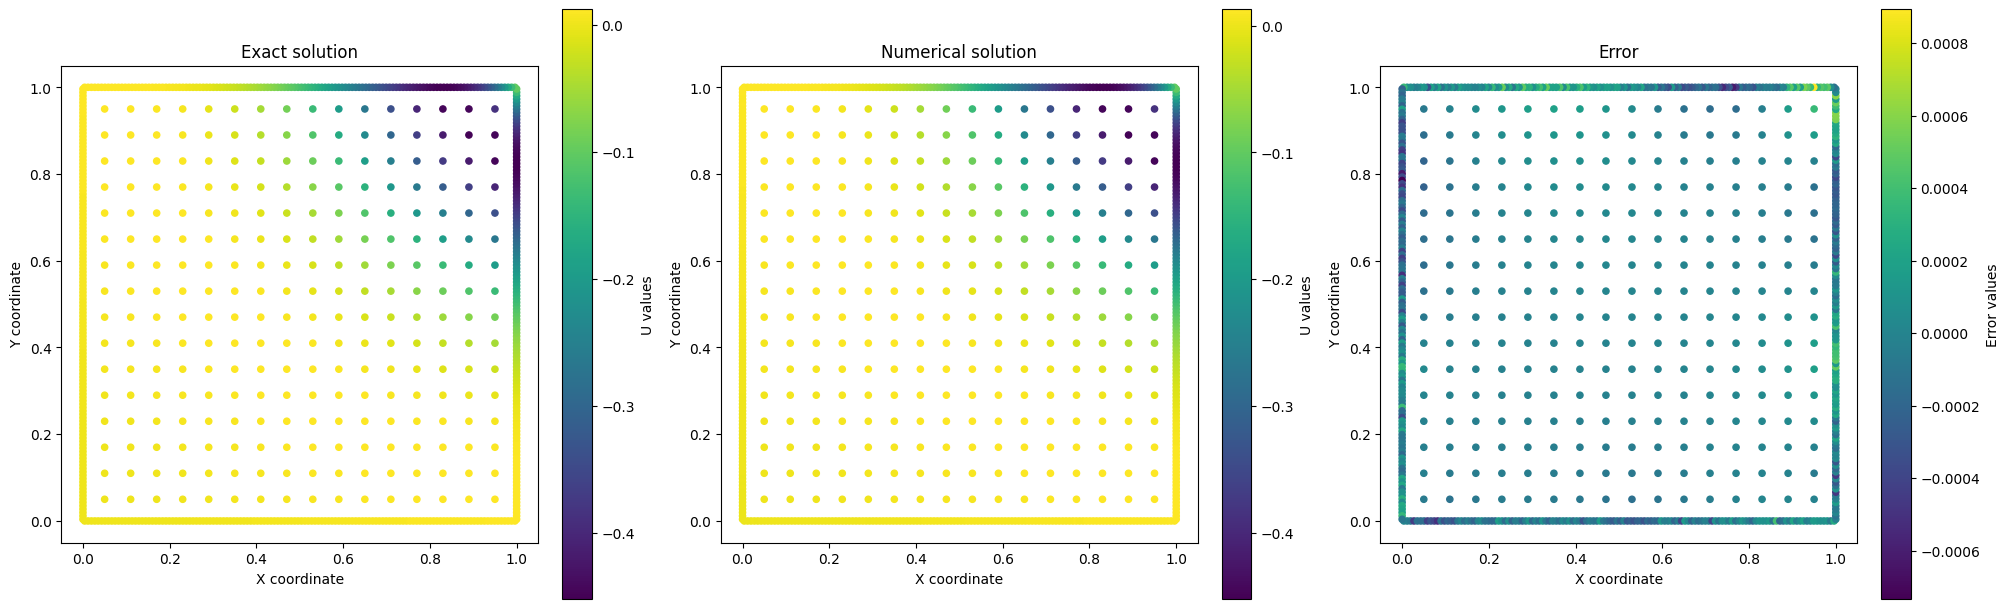

L_inf absolute error: 0.0008935630321502686 || L_2 absolute error: 0.0001925099641084671
L_inf relative error: 0.0019766087643802166 || L_2 relative error: 0.0012421237770467997


In [29]:
validation(0.025, net)